# Bayesian analysis of the second MTurk Experiment (March. 2019)

The goal is to use an ANOVA / ANCOVA style analysis for the experiments; it is possible that the metadata collected (income, education level) play a moderating role. A weakness is that since these are self reported, they may contain substantial noise.

In [1]:
# %load std_ipython_import.txt
import os
import pandas as pd
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import seaborn as sb
import pymc3 as pm

import theano.tensor as tt
from theano.compile.ops import as_op

from scipy.stats import norm
from scipy.stats import t as studentT
from scipy import linalg, sparse, stats

from matplotlib import gridspec
from matplotlib.patches import Rectangle
from matplotlib.ticker import MultipleLocator, FormatStrFormatter

from IPython.display import Image

%matplotlib inline
plt.style.use('seaborn-white')
color = '#87ceeb'

from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['pdf.fonttype'] = 42
rcParams['ps.fonttype'] = 42

from matplotlib import rc
# # Use LaTeX for typesetting
# rc('text', usetex=True)
# # Use ACM standard fonts (Type 1) for numbers and labels
# rc('text.latex',
#    preamble=[
#        r'\usepackage[tt=false, type1=true]{libertine}',
#        r'\usepackage[libertine]{newtxmath}', r'\usepackage[varqu]{zi4}',
#        r'\usepackage[T1]{fontenc}'
#    ])

# Data

In [2]:
# Using dtype 'category' for Y

df = pd.read_csv(
    'data/cs_final.csv'
    #     dtype={
    #         'y': 'int',
    #         'gesture': 'int',
    #         'dist': 'int',
    #         'shading': 'int',
    #         'cond': 'int',
    #         'comicleft': 'int'
    #     }
)

df.rename(
    columns={
        'Q9': 'education',
        'Q8': 'income',
        'Q7': 'gender',
        'text_donation': 'text',
        'comic_donation': 'comic',
        'socialnorm_donation': 'social'
    },
    inplace=True)
# df.info()
dfs = pd.DataFrame()

In [3]:
# adding the response and condition columns
df['condition'] = 0
df.loc[df.text>=0, ['condition']] = "text"
df.loc[df.social>=0, ['condition']] = "comic+social"
df.loc[df.comic>=0, ['condition']] = "comic"

df['response'] = 0
df.loc[df.text>=0, ['response']] = df.text[df.text>=0]
df.loc[df.social>=0, ['response']] = df.social[df.social>=0]
df.loc[df.comic>=0, ['response']] = df.comic[df.comic>=0]

## helper functions from DBDA-Python

https://github.com/JWarmenhoven/DBDA-python

In [4]:
# Calculate Gamma shape and rate from mode and sd.
# if using gamma prior for the class dependent sigma


def gammaShRaFromModeSD(mode, sd):
    rate = (mode + np.sqrt(mode**2 + 4 * sd**2)) / (2 * sd**2)
    shape = 1 + mode * rate
    return (shape, rate)

In [5]:
def plot_mustache(var, sd, j, axis, width=.75):
    for i in np.arange(start=0, stop=len(var), step=int(len(var) * .1)):
        rv = norm(loc=var[i], scale=sd[i])
        yrange = np.linspace(rv.ppf(0.01), rv.ppf(0.99), 100)
        xrange = rv.pdf(yrange)

        # When the SD of a group is large compared to others, then the top of its mustache is relatively
        # low and does not plot well together with low SD groups.
        # Scale the xrange so that the 'height' of the all mustaches is 0.75
        xrange_scaled = xrange * (width / xrange.max())

        # Using the negative value to flip the mustache in the right direction.
        axis.plot(-xrange_scaled + j, yrange, color=color, alpha=.6)

In [6]:
# minor tweak to the plotting function to accomodate the student T

def plot_mustache_studentT(var, sd, j, degree_f, axis, width=.75):
    for i in np.arange(start=0, stop=len(var), step=int(len(var) * .05)):
        rv = studentT(loc=var[i], scale=sd[i], df=degree_f[i])
        yrange = np.linspace(rv.ppf(0.01), rv.ppf(0.99), 100)
        xrange = rv.pdf(yrange)

        # When the SD of a group is large compared to others, then the top of its mustache is relatively
        # low and does not plot well together with low SD groups.
        # Scale the xrange so that the 'height' of the all mustaches is 0.75
        xrange_scaled = xrange * (width / xrange.max())

        # Using the negative value to flip the mustache in the right direction.
        axis.plot(-xrange_scaled + j, yrange, color=color, alpha=.6)

In [7]:
def plot_cred_lines(b0, bj, bcov, x, ax):
    """Plot credible posterior distribution lines for model in section 19.4"""

    B = pd.DataFrame(
        np.c_[b0, bj, bcov], columns=['beta0', 'betaj', 'betacov'])

    # Credible posterior prediction lines
    hpd_interval = pm.hpd(B.values, alpha=0.05)
    B_hpd = B[B.beta0.between(*hpd_interval[0, :])
              & B.betaj.between(*hpd_interval[1, :]) &
              B.betacov.between(*hpd_interval[2, :])]
    xrange = np.linspace(x.min() * .95, x.max() * 1.05)

    for i in np.random.randint(0, len(B_hpd), 10):
        ax.plot(
            xrange,
            B_hpd.iloc[i, 0] + B_hpd.iloc[i, 1] + B_hpd.iloc[i, 2] * xrange,
            c=color,
            alpha=.6,
            zorder=0)

## back to our analysis

In [8]:
# doing all three cases together
m_mean = np.zeros(3)
m_mean[0] = np.mean(df[df.condition=="text"].response)
m_mean[1] = np.mean(df[df.condition=="comic"].response)
m_mean[2] = np.mean(df[df.condition=="comic+social"].response)

m_std = np.zeros(3)
m_std[0] = np.std(df[df.condition=="text"].response)
m_std[1] = np.std(df[df.condition=="comic"].response)
m_std[2] = np.std(df[df.condition=="comic+social"].response)

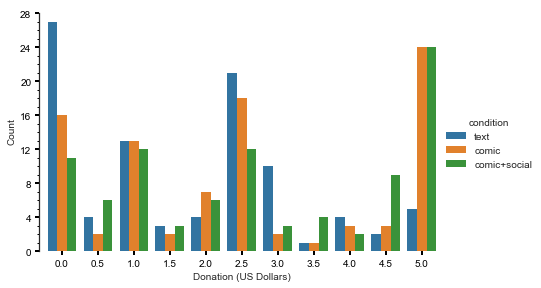

In [9]:
g = sb.catplot(
    hue="condition",
    data=df,
    hue_order=["text", "comic", "comic+social"],
    height=4,
    x="response",
    kind="count",
    aspect=1.5).set(yticks=np.arange(0, 30, 4)).set_axis_labels(
        "Donation (US Dollars)", "Count")

# custom limits requires us to tell where the majot and minor ticks are
majorLocator = MultipleLocator(4) 
minorLocator = MultipleLocator(2)

g.ax.yaxis.set_major_locator(majorLocator)
g.ax.yaxis.set_minor_locator(minorLocator)

g.ax.tick_params(direction='out', length=4, width=2, colors='k', which='major')
g.ax.tick_params(
    direction='out', length=2, width=1, colors='k', which='minor', bottom=False)
g.ax.minorticks_on()
g.despine(offset=5, left=False, bottom=True, trim=True)
g.savefig("contributions across conditions.pdf")

## Defining the model

We have three different groups, who are randomly assigned to text, comic, comic+social conditions. The outcome variable is the degree of contribution. Thus, we have an ANOVA style situation, where we have a metric predicted variable, with a nominal (i.e. the group index) predictor.

We model it as a student-t distribution; the number of degrees of freedom is obtained from an exponential distribution $\nu \sim \exp(-\lambda)$; the mode $\mu \sim \mathcal{N}(a,b)$, spread $\sigma \sim U(L,H)$



In [10]:
# Count the number of records per nominal group
df['condition'] = df['condition'].astype('category')
df.condition.value_counts()

text            94
comic+social    92
comic           91
Name: condition, dtype: int64

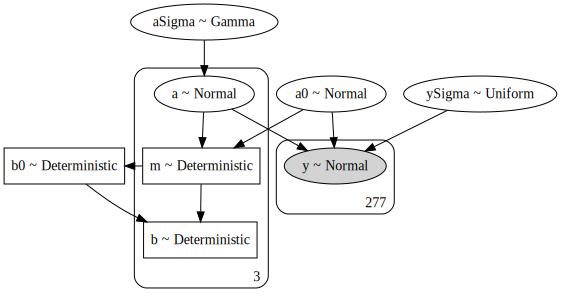

In [11]:
x = df.condition.cat.codes.values
y = df.response

yMean = y.mean()
ySD = y.std()

NxLvl = len(df.condition.cat.categories) # number of groups
agammaShRa = gammaShRaFromModeSD(ySD/2, 2*ySD)

# this model assumes normality
with pm.Model() as SimpleNormalModel:
    
    aSigma = pm.Gamma('aSigma', agammaShRa[0], agammaShRa[1])
    a0 = pm.Normal('a0', yMean, tau=1/(ySD*5)**2)
    a = pm.Normal('a', 0.0, tau=1/aSigma**2, shape=NxLvl)
       
    ySigma = pm.Uniform('ySigma', ySD/100, ySD*10)
    y = pm.Normal('y', a0 + a[x], tau=1/ySigma**2, observed=y)
    
    # Convert a0,a to sum-to-zero b0,b 
    m = pm.Deterministic('m', a0 + a)
    b0 = pm.Deterministic('b0', tt.mean(m))
    b = pm.Deterministic('b', m - b0) 
    
pm.model_to_graphviz(SimpleNormalModel)

In [12]:
tracefile = './traces/simple-normal-case.trace'
# pm.save_trace(trace3, directory=tracefile)

if not os.path.exists(tracefile):
    with SimpleNormalModel:
        SimpleNormalModelTrace = pm.sample(
            20000,  
            nuts_kwargs={'target_accept': 0.95})
    pm.save_trace(SimpleNormalModelTrace, directory=tracefile)
else:
    SimpleNormalModelTrace = pm.load_trace(tracefile, model=SimpleNormalModel)

In [13]:
# with model1:
#     trace1 = pm.sample(5000,nuts_kwargs={'target_accept': 0.95})

In [14]:
print(pm.diagnostics.gelman_rubin(SimpleNormalModelTrace))
print("effective sample size", pm.diagnostics.effective_n(SimpleNormalModelTrace))

{'a0': 1.0002797309898963, 'a': array([1.00029657, 1.00028349, 1.00028454]), 'aSigma': 1.0001017029047405, 'ySigma': 0.9999787153022037, 'm': array([1.00000799, 0.99998453, 0.99997961]), 'b0': 0.9999940535738123, 'b': array([0.99999285, 0.99999405, 0.99997983])}
effective sample size {'a0': 5820.0791905231, 'a': array([5888.10801196, 5891.90359759, 5920.31438968]), 'aSigma': 9237.285403063286, 'ySigma': 40710.415790117346, 'm': array([92814.87749713, 84407.86297   , 73012.26522041]), 'b0': 90365.26925147224, 'b': array([91623.93913204, 78824.29275834, 68854.03355832])}


In [15]:
pm.summary(SimpleNormalModelTrace).round(2)

/usr/local/lib/python3.7/site-packages/pymc3/stats.py:982: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a0,2.32,0.98,0.01,0.26,4.19,5820.08,1.0
a__0,0.21,0.99,0.01,-1.74,2.20,5888.11,1.0
a__1,0.40,0.99,0.01,-1.50,2.44,5891.90,1.0
a__2,-0.53,0.99,0.01,-2.50,1.44,5920.31,1.0
aSigma,1.28,1.21,0.01,0.13,3.59,9237.29,1.0
ySigma,1.76,0.08,0.00,1.61,1.91,40710.42,1.0
m__0,2.52,0.18,0.00,2.16,2.88,92814.88,1.0
m__1,2.72,0.18,0.00,2.36,3.08,84407.86,1.0
m__2,1.78,0.19,0.00,1.42,2.15,73012.27,1.0
b0,2.34,0.11,0.00,2.13,2.55,90365.27,1.0


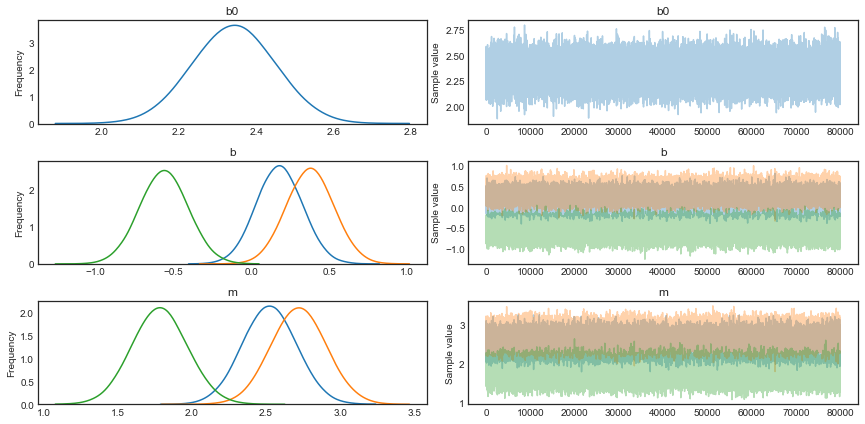

In [16]:
pm.traceplot(SimpleNormalModelTrace, varnames=['b0', 'b', 'm'], combined=True);

## analysing the model parameters

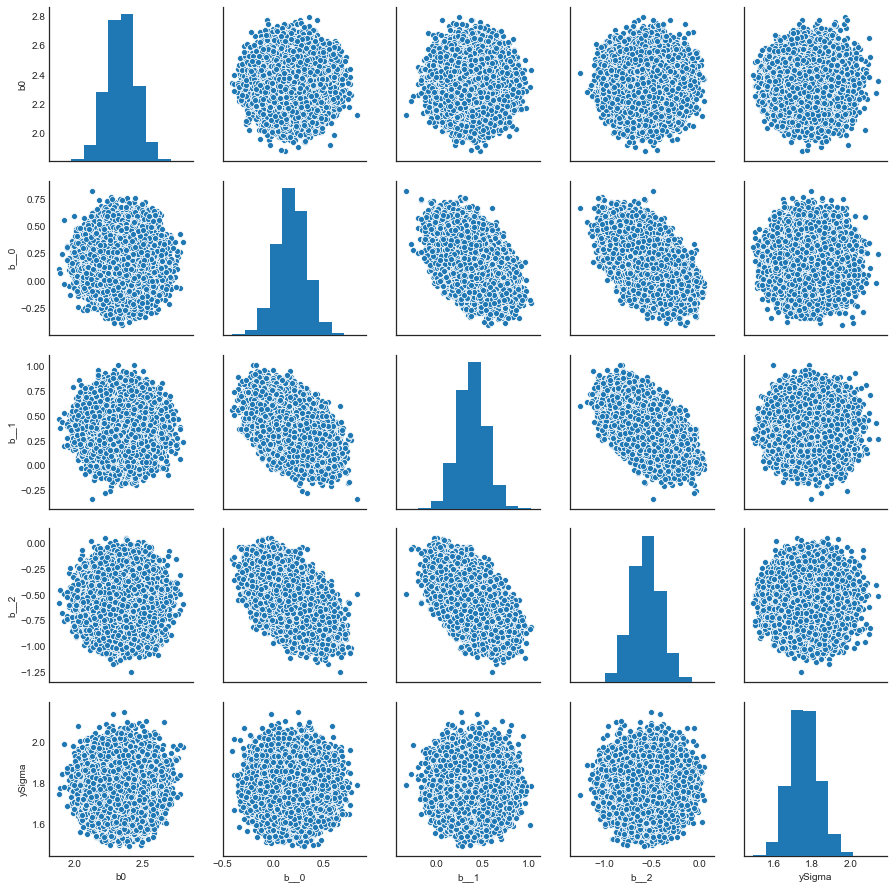

In [17]:
tracedf1 = pm.trace_to_dataframe(SimpleNormalModelTrace, varnames=['b0', 'b', 'ySigma'])
sb.pairplot(tracedf1);

In [18]:
vals = np.array([SimpleNormalModel.dict_to_array(v) for v in SimpleNormalModelTrace[1000:]]).T
vals[:] -= vals.mean(axis=1)[:, None]
vals[:] /= vals.std(axis=1)[:, None]

U, S, Vh = linalg.svd(vals)

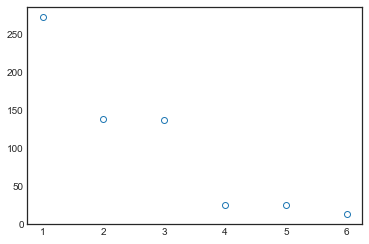

In [19]:
sb.mpl.pyplot.plot(np.arange(1, len(S)+1), S, 'o', mfc='w', mew=1)

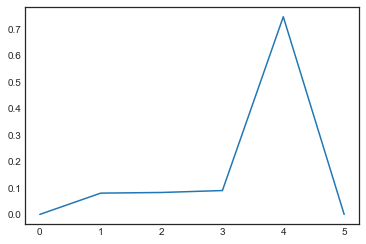

In [20]:
plt.plot(U[:, -1] ** 2)


/usr/local/lib/python3.7/site-packages/matplotlib/axes/_base.py:3215: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
  alternative='`left`', obj_type='argument')


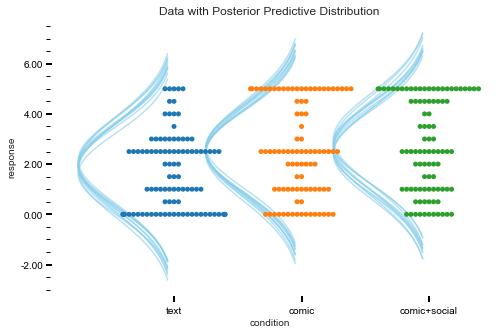

In [21]:
# Here we plot the metric predicted variable for each group. Then we superimpose the
# posterior predictive distribution

comic = SimpleNormalModelTrace['m'][:, 0]
social = SimpleNormalModelTrace['m'][:, 1]
text = SimpleNormalModelTrace['m'][:, 2]
scale = SimpleNormalModelTrace['ySigma'][:]

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.set_title('Data with Posterior Predictive Distribution')

# sb.violinplot(
#     'condition',
#     'response',
#     split=True,
#     data=df,
#     order=["text","comic", "comic+social"],
#     inner=None,
#     ax=ax)

sb.swarmplot(
    'condition',
    'response',
    data=df,
    order=["text","comic", "comic+social"],
#     color="white",
#     edgecolor="gray",
    ax=ax)
ax.set_xlim(xmin=-1)

for i, grp in enumerate([text, comic, social]):
    plot_mustache(grp, scale, i, ax)

z = ax
z.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
z.tick_params(direction='in', length=6, width=2, colors='k', which='major')
z.tick_params(
    direction='in', length=4, width=1, colors='k', which='minor', bottom=False)
z.yaxis.set_ticks_position('left')
z.spines['right'].set_visible(False)
z.spines['top'].set_visible(False)
z.spines['left'].set_visible(False)
z.spines['bottom'].set_visible(False)
z.spines['bottom'].set_position(('outward', 10))

z.minorticks_on()

fig.savefig("data, with SimpleNormalModel posterior predictions.pdf")

## contrasts

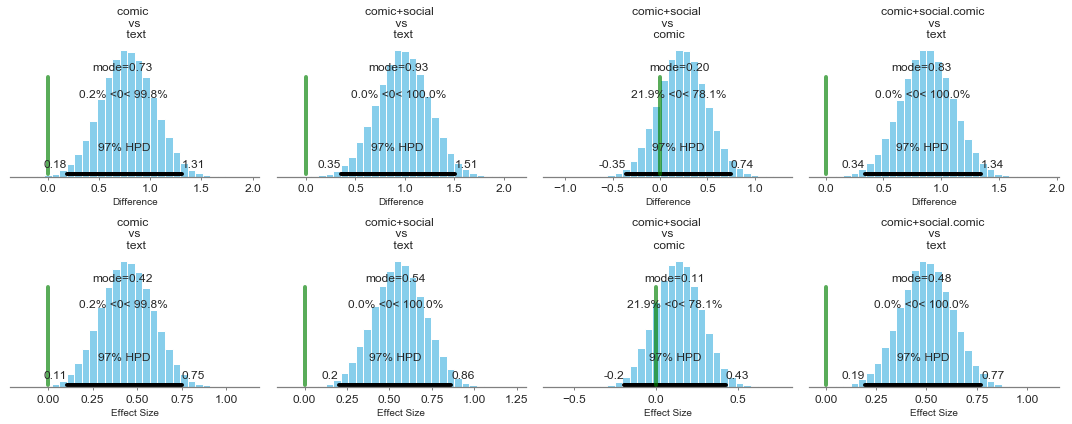

In [22]:
# # Use LaTeX for typesetting
# rc('text', usetex=True)
# # Use ACM standard fonts (Type 1) for numbers and labels
# rc('text.latex',
#    preamble=[
#        r'\usepackage[tt=false, type1=true]{libertine}',
#        r'\usepackage[libertine]{newtxmath}', r'\usepackage[varqu]{zi4}',
#        r'\usepackage[T1]{fontenc}'
#    ])

fig, axes = plt.subplots(2, 4, figsize=(15, 6))

contrasts = [
    comic - text, 
    social - text, 
    social - comic,
    np.mean([comic, social], axis=0) - text
]

contrast_titles = [
    'comic \n vs \n text',
    'comic+social \n vs \n text', 
    'comic+social \n vs \n comic',
    'comic+social.comic \n vs \n text'
]

for contr, ctitle, ax_top, ax_bottom in zip(contrasts, contrast_titles,
                                            fig.axes[:4], fig.axes[4:]):
    pm.plot_posterior(contr, 
                      ref_val=0, 
                      color=color, 
                      point_estimate='mode',
                      alpha_level=0.03,
                      round_to=2,
                      ax=ax_top)
    pm.plot_posterior(contr / scale, 
                      ref_val=0, 
                      point_estimate='mode',
                      round_to=2,
                      alpha_level=0.03,
                      color=color, 
                      ax=ax_bottom)
    ax_top.set_title(ctitle)
    ax_bottom.set_title(ctitle)
    ax_top.set_xlabel('Difference')
    ax_bottom.set_xlabel('Effect Size')
fig.tight_layout()
fig.savefig("basic, SimpleNormal case.pdf")

## case with unequal variances, robust

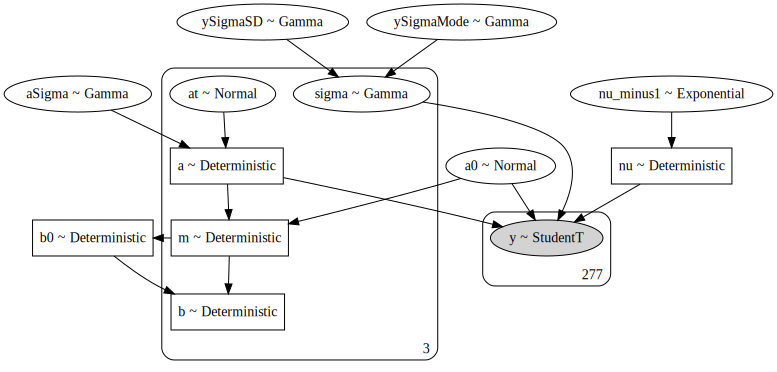

In [23]:
x = df.condition.cat.codes.values
y = df.response

yMean = y.mean()
ySD = y.std()

NxLvl = len(df.condition.cat.categories) # number of groups
aGammaShRa = gammaShRaFromModeSD(ySD/2, 2*ySD)

with pm.Model() as RobustUnequalVariances:
    
    aSigma = pm.Gamma('aSigma', aGammaShRa[0], aGammaShRa[1])
    a0 = pm.Normal('a0', yMean, tau=1/(ySD*10)**2)
    a_t = pm.Normal('at', mu=0, sd=1, shape=NxLvl)
#     a = pm.Normal('a', 0.0, tau=1/aSigma**2, shape=NxLvl)
    a = pm.Deterministic('a', 0.0 + aSigma * a_t) # reparameterization
    
    ySigmaSD = pm.Gamma('ySigmaSD', aGammaShRa[0], aGammaShRa[1])
    ySigmaMode = pm.Gamma('ySigmaMode', aGammaShRa[0], aGammaShRa[1])
    ySigmaRa = (ySigmaMode + np.sqrt(ySigmaMode**2 + 4*ySigmaSD**2))/2*ySigmaSD**2
    ySigmaSh = ySigmaMode*ySigmaRa
        
    ySigma = pm.Gamma('sigma', ySigmaSh, ySigmaRa, shape=NxLvl)
#     ySigma = pm.Deterministic('ySigma', tt.maximum(sigma, medianCellSD/1000))
    nu_minus1 = pm.Exponential('nu_minus1', 1/29.)
    nu = pm.Deterministic('nu', nu_minus1+1)
    like = pm.StudentT('y', nu=nu, mu=a0 + a[x], sd=ySigma[x], observed=y)
    
    # Convert a0,a to sum-to-zero b0,b 
    m = pm.Deterministic('m', a0 + a)
    b0 = pm.Deterministic('b0', tt.mean(m))
    b = pm.Deterministic('b', m - b0)

pm.model_to_graphviz(RobustUnequalVariances)

In [24]:
tracefile = './traces/heterogenous-case.trace'
# pm.save_trace(trace3, directory=tracefile)

if not os.path.exists(tracefile):
    with RobustUnequalVariances:
        RobustUnequalVariancesTrace = pm.sample(
            20000, 
            init='advi+adapt_diag', 
            nuts_kwargs={'target_accept': 0.95})
    pm.save_trace(trace, directory=tracefile)
else:
    RobustUnequalVariancesTrace = pm.load_trace(tracefile, model=RobustUnequalVariances)

In [25]:
# print(pm.diagnostics.gelman_rubin(RobustUnequalVariancesTrace))
# print("effective sample size", pm.diagnostics.effective_n(RobustUnequalVariancesTrace))
pm.summary(RobustUnequalVariancesTrace, alpha=0.03).round(2)

/usr/local/lib/python3.7/site-packages/pymc3/stats.py:982: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_1.5,hpd_98.5,n_eff,Rhat
a0,2.34,0.85,0.01,0.04,4.60,8349.92,1.0
at__0,0.22,0.62,0.00,-1.11,1.60,21969.20,1.0
at__1,0.47,0.66,0.00,-0.97,1.92,21417.07,1.0
at__2,-0.70,0.72,0.01,-2.30,0.79,21038.57,1.0
aSigma,1.25,1.03,0.01,0.12,4.00,10922.29,1.0
a__0,0.18,0.85,0.01,-2.07,2.51,8452.45,1.0
a__1,0.38,0.86,0.01,-1.86,2.72,8429.91,1.0
a__2,-0.57,0.86,0.01,-2.97,1.61,8499.78,1.0
ySigmaSD,4.99,3.22,0.03,0.45,13.08,13042.87,1.0
ySigmaMode,1.76,0.18,0.00,1.38,2.17,20174.37,1.0


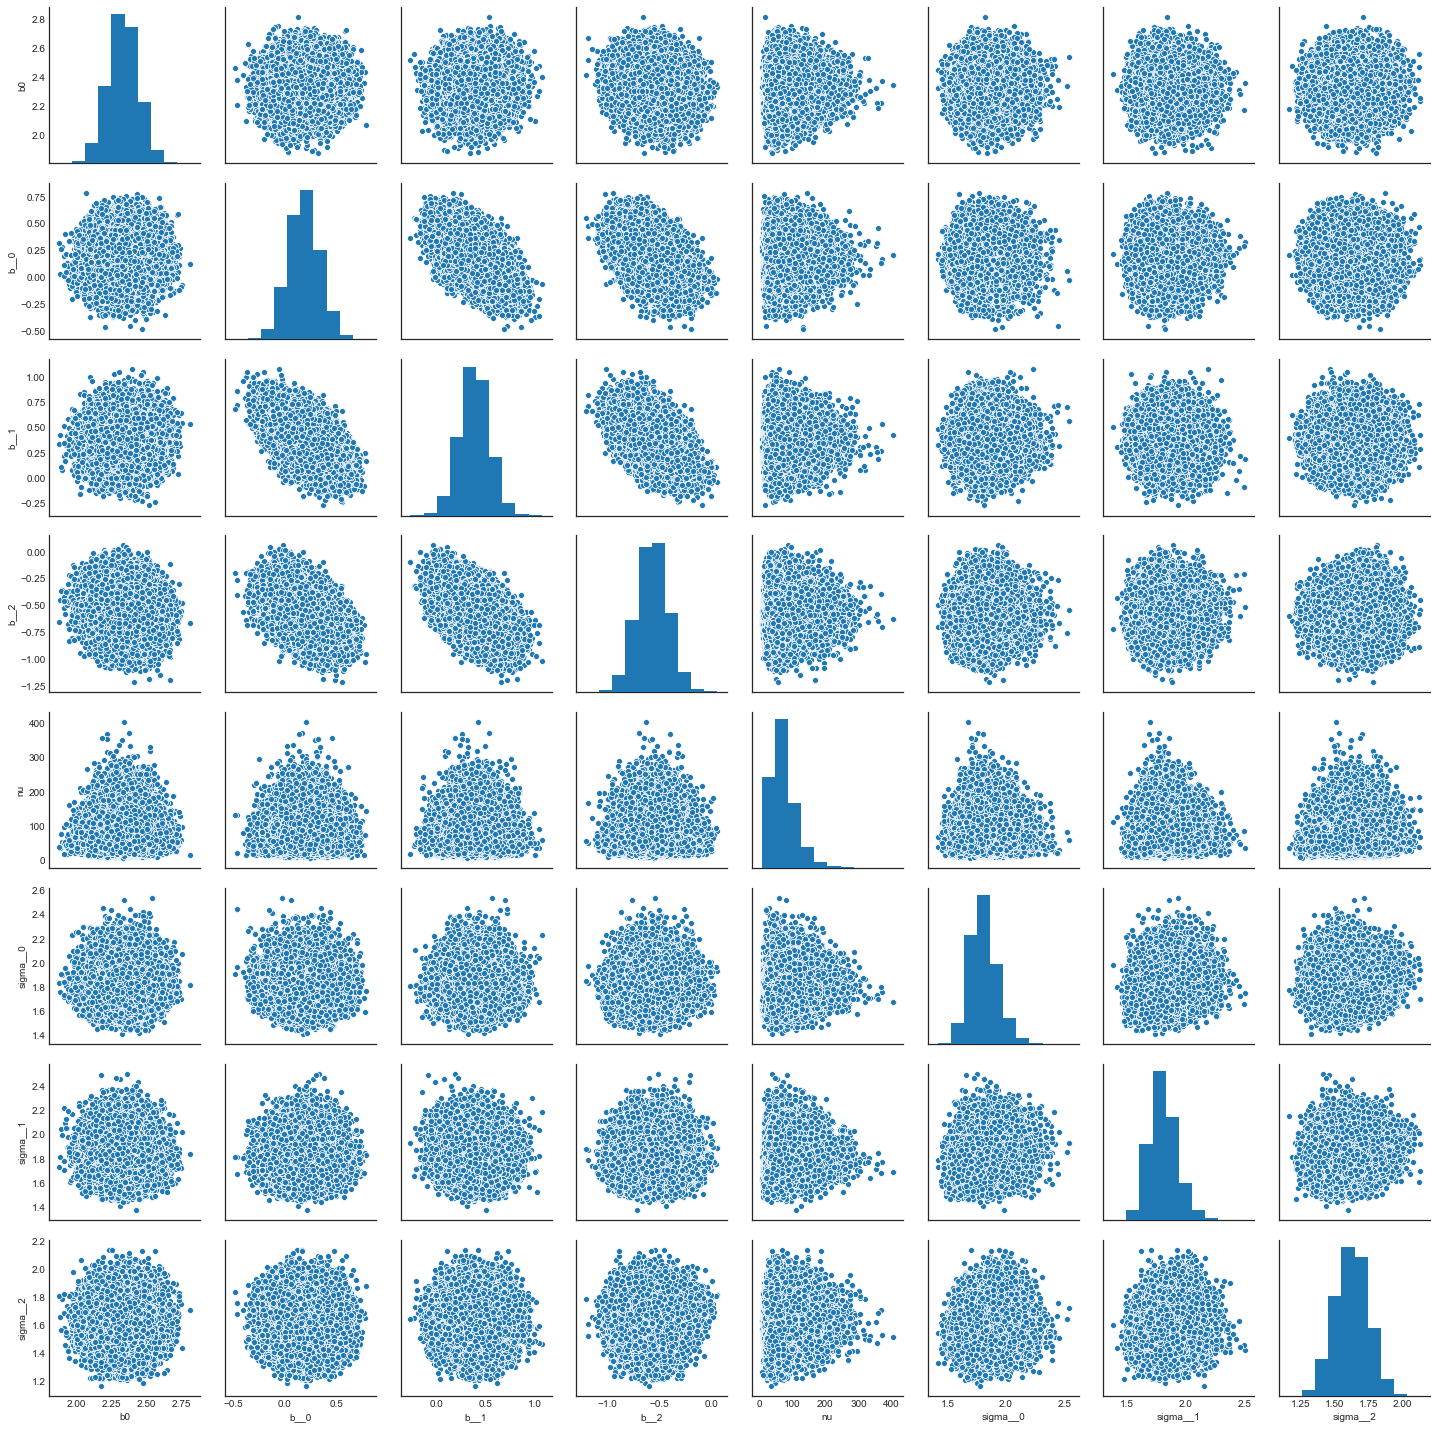

In [26]:
tracedf1 = pm.trace_to_dataframe(RobustUnequalVariancesTrace, varnames=['b0', 'b', 'nu', 'sigma'])
sb.pairplot(tracedf1);

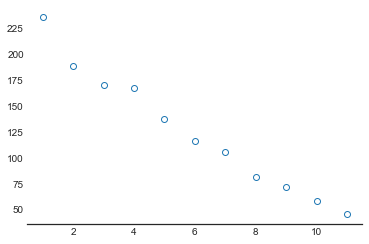

In [27]:
vals = np.array([RobustUnequalVariances.dict_to_array(v) for v in RobustUnequalVariancesTrace[1000:]]).T
vals[:] -= vals.mean(axis=1)[:, None]
vals[:] /= vals.std(axis=1)[:, None]
plt.style.use('seaborn-white')
U, S, Vh = linalg.svd(vals)
sb.mpl.pyplot.plot(np.arange(1, len(S)+1), S, 'o', mfc='w', mew=1)
sb.despine(left=True)

## posterior predictive check

/usr/local/lib/python3.7/site-packages/matplotlib/axes/_base.py:3215: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
  alternative='`left`', obj_type='argument')


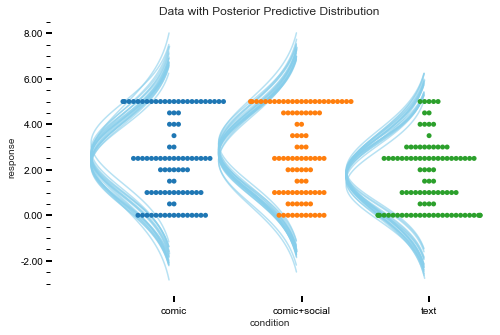

In [28]:
# Here we plot the metric predicted variable for each group. Then we superimpose the
# posterior predictive distribution

comic = RobustUnequalVariancesTrace['m'][:, 0]
social = RobustUnequalVariancesTrace['m'][:, 1]
text = RobustUnequalVariancesTrace['m'][:, 2]
scale = RobustUnequalVariancesTrace['sigma'][:]
d_f = RobustUnequalVariancesTrace['nu']

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.set_title('Data with Posterior Predictive Distribution')

sb.swarmplot(
    'condition',
    'response',
    data=df,
    order=["comic", "comic+social", "text"], ax=ax)
ax.set_xlim(xmin=-1)


for i, grp in enumerate([comic, social, text]):
    sd = RobustUnequalVariancesTrace['sigma'][:,i]
    # plotting mustaches with the student t; the original function uses a normal dist
    plot_mustache_studentT(var=grp, sd=sd, j=i, degree_f=d_f, axis=ax, width=0.65)

z = ax
z.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
z.tick_params(direction='in', length=6, width=2, colors='k', which='major')
z.tick_params(
    direction='in', length=4, width=1, colors='k', which='minor', bottom=False)
z.yaxis.set_ticks_position('left')
z.spines['right'].set_visible(False)
z.spines['top'].set_visible(False)
z.spines['left'].set_visible(False)
z.spines['bottom'].set_visible(False)
z.spines['bottom'].set_position(('outward', 10))

z.minorticks_on()

fig.savefig("Robust Unequal Variances, posterior predictions.pdf")

## contrasts

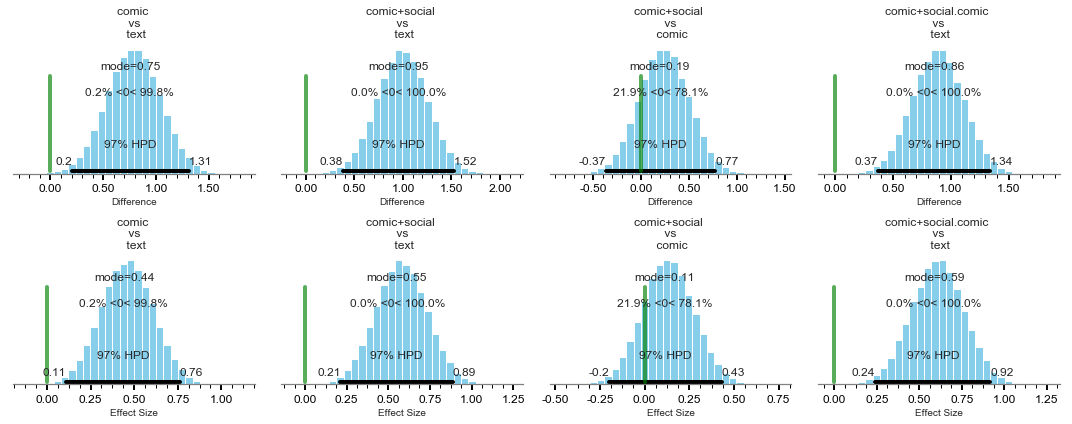

In [29]:
fig, axes = plt.subplots(2, 4, figsize=(15, 6))

comic = RobustUnequalVariancesTrace['m'][:, 0]
social = RobustUnequalVariancesTrace['m'][:, 1]
text = RobustUnequalVariancesTrace['m'][:, 2]
scale = RobustUnequalVariancesTrace['sigma'][:]

contrasts = [
    comic - text, 
    social - text, 
    social - comic,
    np.mean([comic, social], axis=0) - text
]

cscale = np.zeros((len(comic), 4))
cscale[:, 0] = np.sqrt((scale[:, 0]**2 + scale[:, 2]**2) / 2)  # comic, text
cscale[:, 1] = np.sqrt((scale[:, 1]**2 + scale[:, 2]**2) / 2)  # social, text
cscale[:, 2] = np.sqrt((scale[:, 1]**2 + scale[:, 0]**2) / 2)  # social, comic

t = np.sqrt((scale[:, 1]**2 + scale[:, 0]**2) / 4)  # variance of mean of comic and social
cscale[:, 3] = np.sqrt(
    (t**2 + scale[:, 2]**2) / 2)  # variance of mean of comic and social, text

sd = [cscale[:,0],
      cscale[:,1],
      cscale[:,2],
      cscale[:,3]
]

contrast_titles = [
    'comic \n vs \n text', 
    'comic+social \n vs \n text',
    'comic+social \n vs \n comic', 
    'comic+social.comic \n vs \n text'
]

for contr, csd, ctitle, ax_top, ax_bottom in zip(contrasts, sd, contrast_titles,
                                            fig.axes[:4], fig.axes[4:]):
    pm.plot_posterior(contr, ref_val=0, 
                      color=color, 
                      point_estimate='mode',
                      alpha_level=0.03,
                      round_to=2,
                      ax=ax_top)
    pm.plot_posterior(contr / csd, ref_val=0, 
                      color=color, 
                      point_estimate='mode',
                      alpha_level=0.03,
                      round_to=2,
                      ax=ax_bottom) # use this!!
#     pm.plot_posterior(contr, ref_val=0, color=color, ax=ax_bottom)
    ax_top.set_title(ctitle)
    ax_bottom.set_title(ctitle)
    
    ax_top.set_xlabel('Difference')
    ax_bottom.set_xlabel('Effect Size')
    
    ax_top.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax_bottom.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    
    ax_top.tick_params(direction='out', length=6, width=2, colors='k', which='major')
    ax_bottom.tick_params(direction='out', length=6, width=2, colors='k', which='major')
    
    ax_top.tick_params(direction='out', length=4, width=1, colors='k', which='minor')
    ax_bottom.tick_params(direction='out', length=4, width=1, colors='k', which='minor')
    
    ax_top.xaxis.set_ticks_position('bottom')
    ax_bottom.xaxis.set_ticks_position('bottom')
    
    ax_top.minorticks_on()
    ax_bottom.minorticks_on()
    
    
# z = axes
# z.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# # z.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# z.tick_params(direction='in', length=6, width=2, colors='k', which='major')
# z.tick_params(direction='in', length=4, width=1, colors='k', which='minor')
# z.xaxis.set_ticks_position('bottom')
# # z.yaxis.set_ticks_position('left')
# z.minorticks_on()

# fig.tight_layout()

fig.tight_layout()
fig.savefig("Robust Unequal Variances, differences and effects.pdf")

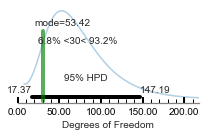

In [30]:
# checking normality

fig, axs = sb.mpl.pyplot.subplots(1, 1)  #### change on changing parameters
fig.set_size_inches(3, 2)

pm.plot_posterior(
    RobustUnequalVariancesTrace['nu'],
    point_estimate='mode',
    kde_plot='True',
    round_to=2,
    ref_val=30,
    text_size=10,
    ax=axs)

z = axs
# s = "$\mu$"
z.set_xlabel("Degrees of Freedom")

center = RobustUnequalVariancesTrace['nu'].mean()
z.set_xlim([0, 3*center])
z.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# z.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
z.tick_params(direction='in', length=6, width=2, colors='k', which='major')
z.tick_params(direction='in', length=4, width=1, colors='k', which='minor')
z.xaxis.set_ticks_position('bottom')
# z.set_xscale('log')
# z.yaxis.set_ticks_position('left')
z.minorticks_on()

fig.tight_layout()
fig.savefig("Robust Unequal Variances Trace, normality parameter.pdf")


## traceplots

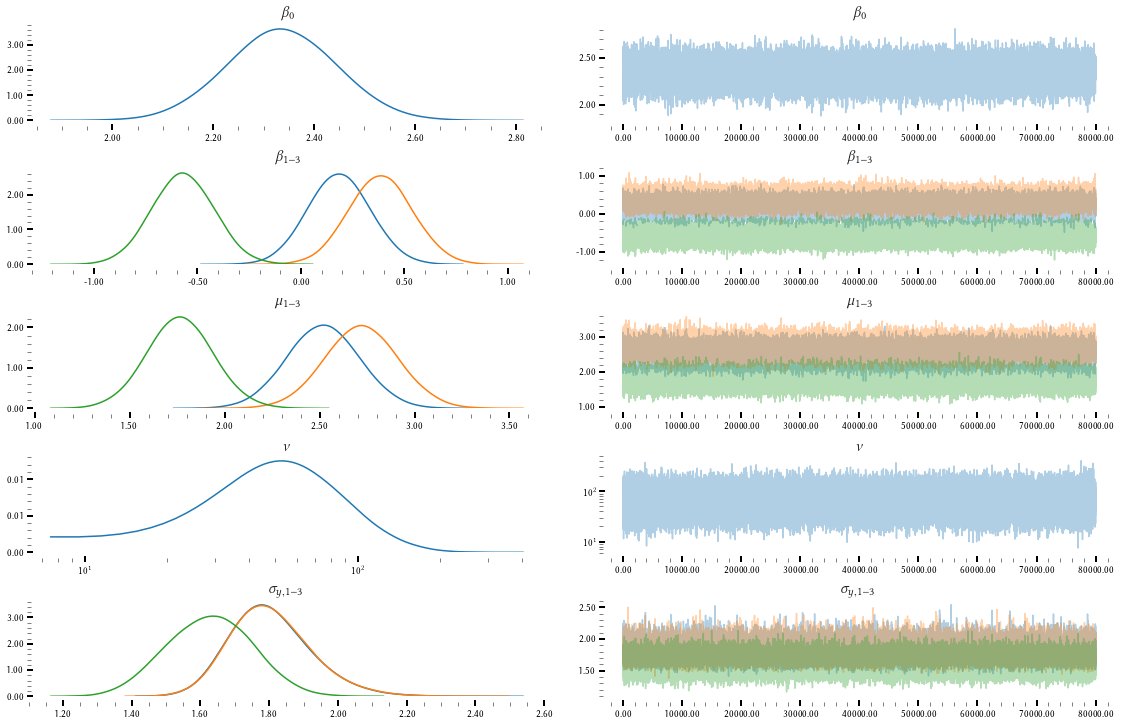

In [31]:
beta0 = RobustUnequalVariancesTrace['b0']
beta1 = RobustUnequalVariancesTrace['b'][:,0]
beta2 = RobustUnequalVariancesTrace['b'][:,1]
beta3 = RobustUnequalVariancesTrace['b'][:,2]

ysigma1 = RobustUnequalVariancesTrace['sigma'][:,0]
ysigma2 = RobustUnequalVariancesTrace['sigma'][:,1]
ysigma3 = RobustUnequalVariancesTrace['sigma'][:,2]

# Use LaTeX for typesetting
rc('text', usetex=True)
# Use ACM standard fonts (Type 1) for numbers and labels
rc('text.latex',
   preamble=[
       r'\usepackage[tt=false, type1=true]{libertine}',
       r'\usepackage[libertine]{newtxmath}', 
       r'\usepackage[varqu]{zi4}',
       r'\usepackage[T1]{fontenc}'
   ])

NRows = 5 # four variables to show
NCols = 2
fig, axs = sb.mpl.pyplot.subplots(NRows, NCols)

fig.set_size_inches(NCols*8, NRows*2)


pm.traceplot(RobustUnequalVariancesTrace, 
             varnames=['b0', 'b', 'm', 'nu', 'sigma'], 
             combined=True,
            ax=axs);

for i in range(NRows):
    for j in range(NCols):
        z = axs[i, j]
        z.set_xlabel("") # no individual labels
        z.set_ylabel("")
        z.spines['right'].set_visible(False)
        z.spines['top'].set_visible(False)
        z.spines['left'].set_visible(False)
        z.spines['bottom'].set_visible(False)
        z.spines['bottom'].set_position(('outward', 10))
        z.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        z.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        z.tick_params(direction='in', length=6, width=2, colors='k', which='major')
        z.tick_params(direction='in', length=4, width=1, colors='gray', which='minor')
        z.minorticks_on()

axs[3,0].set_xscale('log')
axs[3,1].set_yscale('log')

axs[0,0].set_title(r'$\beta_0$', size=16)
axs[0,1].set_title(r'$\beta_0$', size=16)
axs[1,0].set_title(r'$\beta_{1-3}$', size=16)
axs[1,1].set_title(r'$\beta_{1-3}$', size=16)
axs[2,0].set_title(r'$\mu_{1-3}$', size=16)
axs[2,1].set_title(r'$\mu_{1-3}$', size=16)
axs[3,0].set_title(r'$\nu$', size=16)
axs[3,1].set_title(r'$\nu$', size=16)
axs[4,0].set_title(r'$\sigma_{y, 1-3}$', size=16)
axs[4,1].set_title(r'$\sigma_{y, 1-3}$', size=16)

plt.subplots_adjust(hspace=0.5,
                    wspace=0.1)

fig.savefig('RobustUnequalVariances_traceplot.pdf')

## Forest Plot

/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


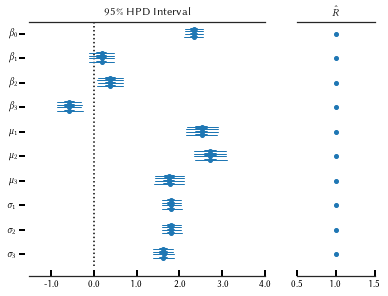

In [32]:
rc('text', usetex=True)
rc('text.latex',
   preamble=[
       r'\usepackage[tt=false, type1=true]{libertine}',
       r'\usepackage[libertine]{newtxmath}', r'\usepackage[varqu]{zi4}',
       r'\usepackage[T1]{fontenc}'
   ])
gs = pm.forestplot(
    RobustUnequalVariancesTrace,
    varnames=['b0', 'b', 'm', 'sigma'],
    quartiles=True,
    ylabels=[
        '$\\beta_0$', '$\\beta_1$', '$\\beta_2$', '$\\beta_3$', '$\\mu_1$',
        '$\\mu_2$', '$\\mu_3$', '$\\sigma_1$', '$\\sigma_2$', '$\\sigma_3$'
    ])
z = plt.subplot(gs[0])

# sb.despine(ax=z, trim=True)

z.set_xlim([-1.5, 4])
z.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
z.tick_params(direction='in', length=6, width=2, colors='k', which='major')
# z.tick_params(direction='in', length=4, width=1, colors='k', which='minor')
# z.xaxis.set_ticks_position('bottom')
# z.set_xscale('log')
z.set_title('$95\%$ HPD Interval')
z.spines['right'].set_visible(False)
# z.spines['top'].set_visible(False)
z.spines['left'].set_visible(False)
z.spines['left'].set_position(('outward', 10))
# z.spines['bottom'].set_visible(False)
z.spines['bottom'].set_position(('outward', 10))
z.yaxis.set_ticks_position('left')

# sb.despine(ax=z, trim=True)
z = plt.subplot(gs[1])

z.set_xlim([0.5, 1.5])
z.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
z.tick_params(direction='in', length=6, width=2, colors='k', which='major')
# z.tick_params(direction='in', length=4, width=1, colors='k', which='minor')
# z.xaxis.set_ticks_position('bottom')
# z.set_xscale('log')
z.set_title('$\hat{R}$')
z.spines['right'].set_visible(False)
# z.spines['top'].set_visible(False)
z.spines['left'].set_visible(False)
# z.spines['bottom'].set_visible(False)
z.spines['bottom'].set_position(('outward', 10))
z.yaxis.set_ticks_position('left')


plt.savefig('rhat-robust.pdf', bbox_inches = 'tight')

# z.minorticks_on()

/usr/local/lib/python3.7/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


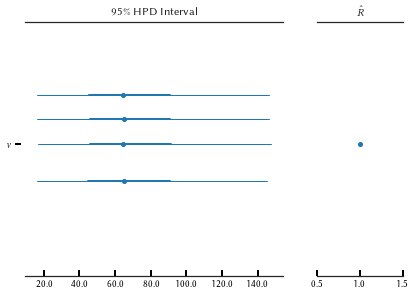

In [33]:
gs = pm.forestplot(
    RobustUnequalVariancesTrace,
    varnames=['nu'],
    quartiles=True,
    ylabels=[
        '$\\nu$'
    ])

z = plt.subplot(gs[0])
# z.set_xlim([-1.5, 4])
z.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
z.tick_params(direction='in', length=6, width=2, colors='k', which='major')
# z.tick_params(direction='in', length=4, width=1, colors='k', which='minor')
# z.xaxis.set_ticks_position('bottom')
# z.set_xscale('log')
z.set_title('$95\%$ HPD Interval')
z.spines['right'].set_visible(False)
# z.spines['top'].set_visible(False)
z.spines['left'].set_visible(False)
z.spines['left'].set_position(('outward', 10))
# z.spines['bottom'].set_visible(False)
z.spines['bottom'].set_position(('outward', 10))
z.yaxis.set_ticks_position('left')

# sb.despine(ax=z, trim=True)
z = plt.subplot(gs[1])

z.set_xlim([0.5, 1.5])
z.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
z.tick_params(direction='in', length=6, width=2, colors='k', which='major')
# z.tick_params(direction='in', length=4, width=1, colors='k', which='minor')
# z.xaxis.set_ticks_position('bottom')
# z.set_xscale('log')
z.set_title('$\hat{R}$')
z.spines['right'].set_visible(False)
# z.spines['top'].set_visible(False)
z.spines['left'].set_visible(False)
# z.spines['bottom'].set_visible(False)
z.spines['bottom'].set_position(('outward', 10))
z.yaxis.set_ticks_position('left')

# Robust Case Simple

Let's examine the case when just the likelihood function is StudentT but everything else is kept simple

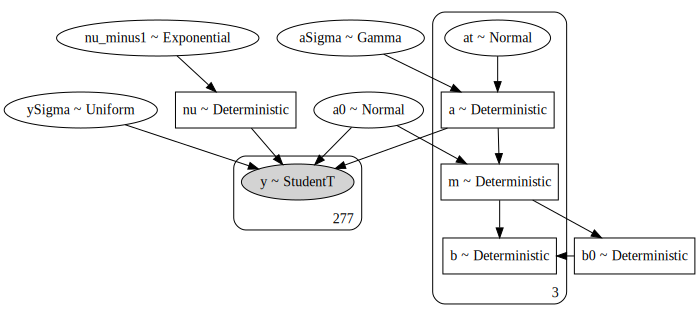

In [34]:
x = df.condition.cat.codes.values
y = df.response

yMean = y.mean()
ySD = y.std()

NxLvl = len(df.condition.cat.categories) # number of groups
agammaShRa = gammaShRaFromModeSD(ySD/2, 2*ySD)

# this model assumes normality
with pm.Model() as StudentTModelEqualVariance:
    
    aSigma = pm.Gamma('aSigma', agammaShRa[0], agammaShRa[1])    
    a0 = pm.Normal('a0', yMean, tau=1/(ySD*10)**2)
    a_t = pm.Normal('at', mu=0, sd=1, shape=NxLvl)
    a = pm.Deterministic('a', 0.0 + aSigma * a_t) # reparameterization
       
    ySigma = pm.Uniform('ySigma', ySD/100, ySD*10)
    
    nu_minus1 = pm.Exponential('nu_minus1', 1/29.)
    nu = pm.Deterministic('nu', nu_minus1+1)
    like = pm.StudentT('y', nu=nu, mu=a0 + a[x], sd=ySigma, observed=y)
    
    # Convert a0,a to sum-to-zero b0,b 
    m = pm.Deterministic('m', a0 + a)
    b0 = pm.Deterministic('b0', tt.mean(m))
    b = pm.Deterministic('b', m - b0) 
    
pm.model_to_graphviz(StudentTModelEqualVariance)

In [35]:
tracefile = './traces/student-equalvariances-case.trace'
# pm.save_trace(trace3, directory=tracefile)

if not os.path.exists(tracefile):
    with StudentTModelEqualVariance:
        StudentTModelEqualVarianceTrace = pm.sample(
            20000, 
            init='advi+adapt_diag', 
            nuts_kwargs={'target_accept': 0.95})
    pm.save_trace(StudentTModelEqualVarianceTrace, directory=tracefile)
else:
    StudentTModelEqualVarianceTrace = pm.load_trace(tracefile, model=StudentTModelEqualVariance)

In [36]:
pm.summary(StudentTModelEqualVarianceTrace, alpha=0.03).round(2)

/usr/local/lib/python3.7/site-packages/pymc3/stats.py:982: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  axis=1, join_axes=[dforg.index])


,mean,sd,mc_error,hpd_1.5,hpd_98.5,n_eff,Rhat
a0,2.32,0.82,0.02,0.13,4.71,3037.33,1.0
at__0,0.23,0.62,0.00,-1.10,1.61,21799.33,1.0
at__1,0.49,0.66,0.00,-0.88,1.98,21697.33,1.0
at__2,-0.70,0.72,0.01,-2.28,0.80,14923.08,1.0
aSigma,1.23,1.03,0.02,0.11,4.06,2595.08,1.0
a__0,0.20,0.83,0.02,-2.19,2.40,3056.55,1.0
a__1,0.40,0.83,0.02,-1.91,2.69,2976.62,1.0
a__2,-0.54,0.83,0.02,-2.95,1.64,3122.04,1.0
ySigma,1.75,0.08,0.00,1.58,1.91,52341.66,1.0
nu_minus1,71.79,37.30,0.18,13.37,160.13,52545.64,1.0


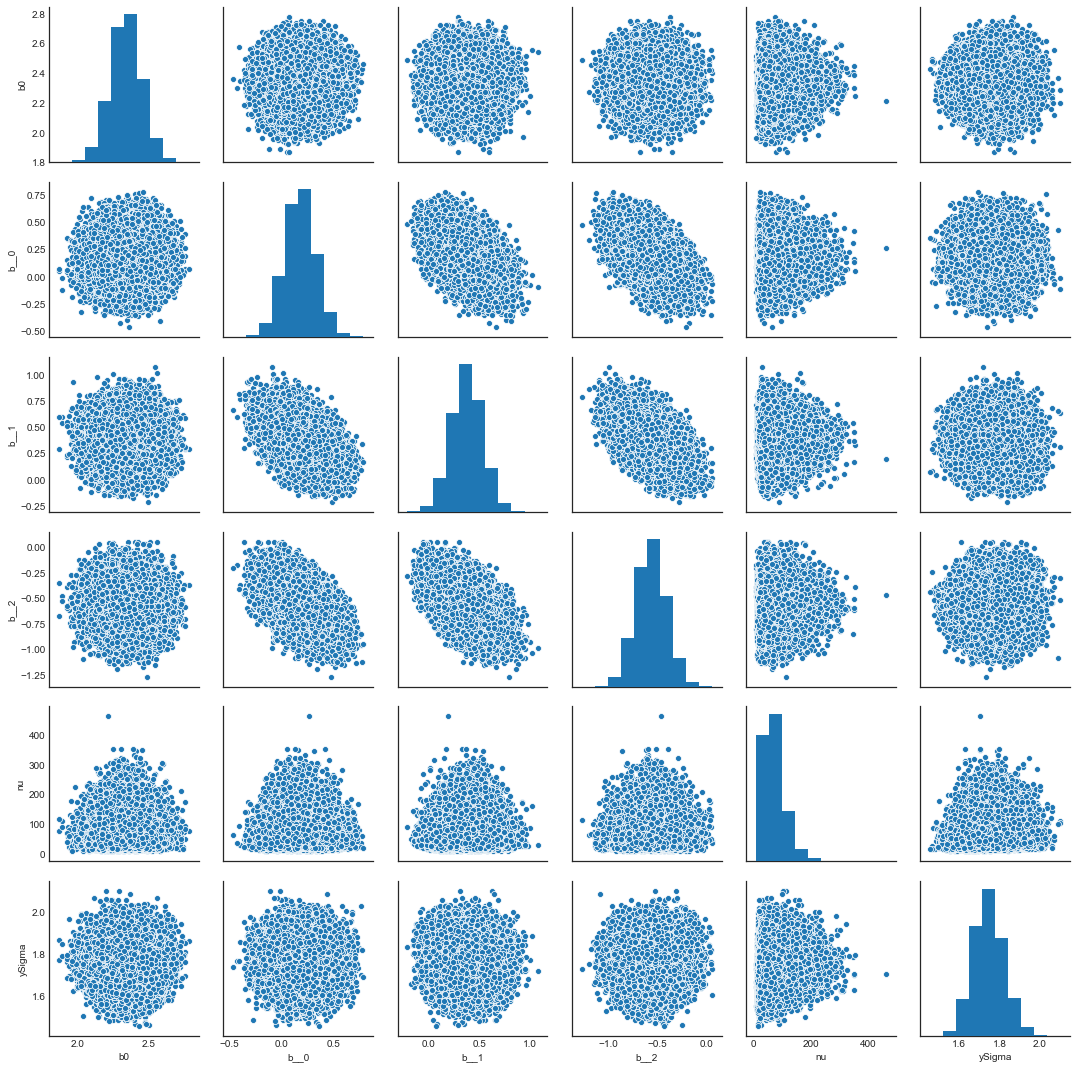

In [37]:
rc('text', usetex=False)
tracedf1 = pm.trace_to_dataframe(StudentTModelEqualVarianceTrace, varnames=['b0', 'b', 'nu', 'ySigma'])
sb.pairplot(tracedf1);

## Posterior Predictive Check

/usr/local/lib/python3.7/site-packages/matplotlib/axes/_base.py:3215: MatplotlibDeprecationWarning: 
The `xmin` argument was deprecated in Matplotlib 3.0 and will be removed in 3.2. Use `left` instead.
  alternative='`left`', obj_type='argument')


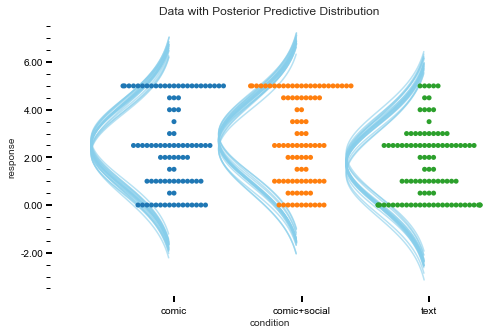

In [38]:
# Here we plot the metric predicted variable for each group. Then we superimpose the
# posterior predictive distribution

comic = StudentTModelEqualVarianceTrace['m'][:, 0]
social = StudentTModelEqualVarianceTrace['m'][:, 1]
text = StudentTModelEqualVarianceTrace['m'][:, 2]
scale = StudentTModelEqualVarianceTrace['ySigma'][:]
d_f = StudentTModelEqualVarianceTrace['nu']

fig, ax = plt.subplots(1, 1, figsize=(8, 5))
ax.set_title('Data with Posterior Predictive Distribution')

sb.swarmplot(
    'condition',
    'response',
    data=df,
    order=["comic", "comic+social", "text"], ax=ax)
ax.set_xlim(xmin=-1)


for i, grp in enumerate([comic, social, text]):
    sd = StudentTModelEqualVarianceTrace['ySigma']
    # plotting mustaches with the student t; the original function uses a normal dist
    plot_mustache_studentT(var=grp, sd=sd, j=i, degree_f=d_f, axis=ax, width=0.65)

z = ax
z.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
z.tick_params(direction='in', length=6, width=2, colors='k', which='major')
z.tick_params(
    direction='in', length=4, width=1, colors='k', which='minor', bottom=False)
z.yaxis.set_ticks_position('left')
z.spines['right'].set_visible(False)
z.spines['top'].set_visible(False)
z.spines['left'].set_visible(False)
z.spines['bottom'].set_visible(False)
z.spines['bottom'].set_position(('outward', 10))

z.minorticks_on()

fig.savefig("StudentT Equal Variances, posterior predictions.pdf")

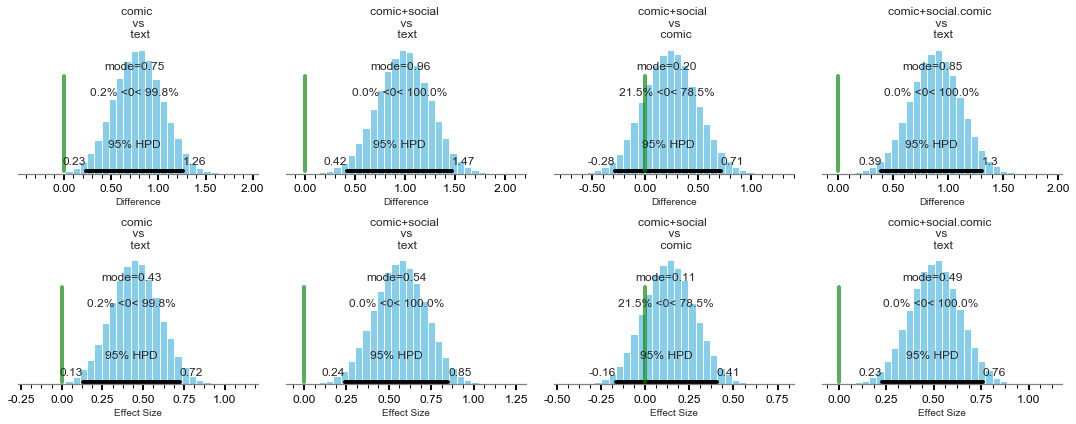

In [39]:
rc('text', usetex=False)
fig, axes = plt.subplots(2, 4, figsize=(15, 6))
trace = StudentTModelEqualVarianceTrace

comic = trace['m'][:, 0]
social = trace['m'][:, 1]
text = trace['m'][:, 2]
scale = trace['ySigma'][:]

contrasts = [
    comic - text, 
    social - text, 
    social - comic,
    np.mean([comic, social], axis=0) - text
]

cscale = scale


contrast_titles = [
    'comic \n vs \n text', 
    'comic+social \n vs \n text',
    'comic+social \n vs \n comic', 
    'comic+social.comic \n vs \n text'
]

for contr, ctitle, ax_top, ax_bottom in zip(contrasts, contrast_titles,
                                            fig.axes[:4], fig.axes[4:]):
    pm.plot_posterior(contr, ref_val=0, 
                      color=color, 
                      point_estimate='mode',
                      alpha_level=0.05,
                      round_to=2,
                      ax=ax_top)
    pm.plot_posterior(contr / cscale, ref_val=0, 
                      color=color, 
                      point_estimate='mode',
                      alpha_level=0.05,
                      round_to=2,
                      ax=ax_bottom) # use this!!
#     pm.plot_posterior(contr, ref_val=0, color=color, ax=ax_bottom)
    ax_top.set_title(ctitle)
    ax_bottom.set_title(ctitle)
    
    ax_top.set_xlabel('Difference')
    ax_bottom.set_xlabel('Effect Size')
    
    ax_top.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax_bottom.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    
    ax_top.tick_params(direction='out', length=6, width=2, colors='k', which='major')
    ax_bottom.tick_params(direction='out', length=6, width=2, colors='k', which='major')
    
    ax_top.tick_params(direction='out', length=4, width=1, colors='k', which='minor')
    ax_bottom.tick_params(direction='out', length=4, width=1, colors='k', which='minor')
    
    ax_top.xaxis.set_ticks_position('bottom')
    ax_bottom.xaxis.set_ticks_position('bottom')
    
    ax_top.minorticks_on()
    ax_bottom.minorticks_on()
    
    
# z = axes
# z.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# # z.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# z.tick_params(direction='in', length=6, width=2, colors='k', which='major')
# z.tick_params(direction='in', length=4, width=1, colors='k', which='minor')
# z.xaxis.set_ticks_position('bottom')
# # z.yaxis.set_ticks_position('left')
# z.minorticks_on()

# fig.tight_layout()

fig.tight_layout()
fig.savefig("StudentT Equal Variances, differences and effects.pdf")


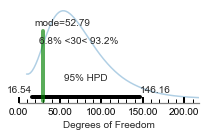

In [40]:
fig, axs = sb.mpl.pyplot.subplots(1, 1)  #### change on changing parameters
fig.set_size_inches(3, 2)

trace = StudentTModelEqualVarianceTrace

pm.plot_posterior(
    trace['nu'],
    point_estimate='mode',
    kde_plot='True',
    round_to=2,
    ref_val=30,
    text_size=10,
    ax=axs)

z = axs
# s = "$\mu$"
z.set_xlabel("Degrees of Freedom")

center = trace['nu'].mean()
z.set_xlim([0, 3*center])
z.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
# z.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
z.tick_params(direction='in', length=6, width=2, colors='k', which='major')
z.tick_params(direction='in', length=4, width=1, colors='k', which='minor')
z.xaxis.set_ticks_position('bottom')
# z.set_xscale('log')
# z.yaxis.set_ticks_position('left')
z.minorticks_on()

fig.tight_layout()
fig.savefig("StudentT Equal Variances Trace, normality parameter.pdf")

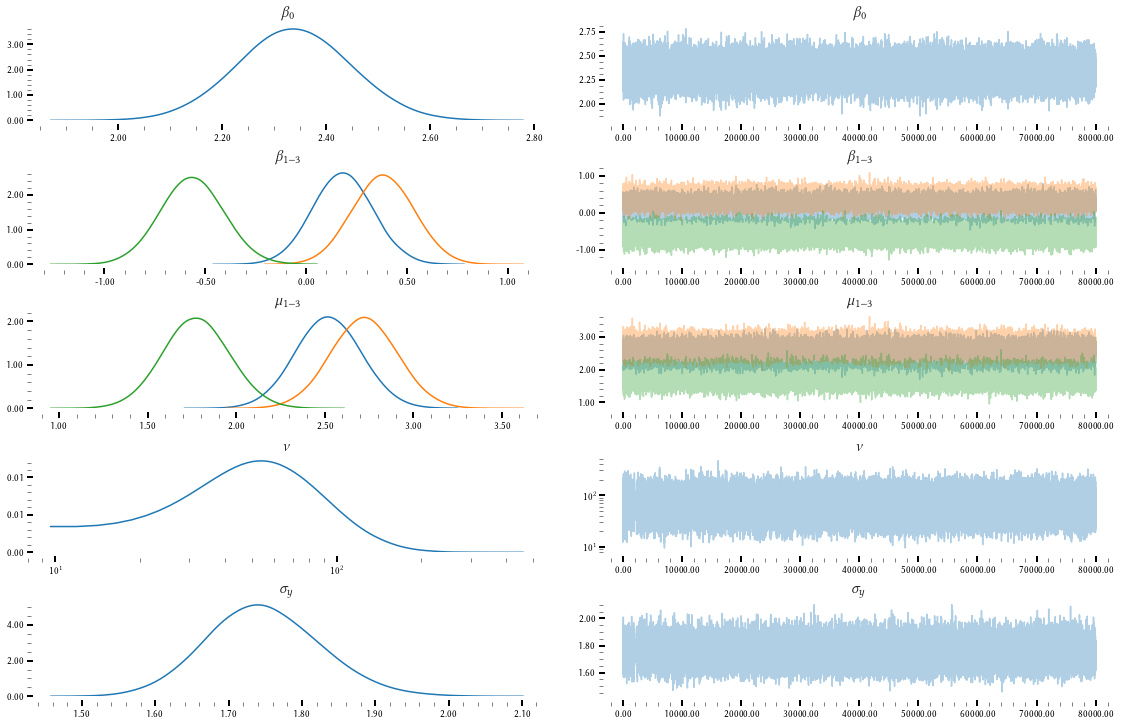

In [41]:
trace = StudentTModelEqualVarianceTrace
# beta0 = trace['b0']
# beta1 = trace['b'][:,0]
# beta2 = trace['b'][:,1]
# beta3 = trace['b'][:,2]

# ysigma1 = trace['sigma'][:,0]
# ysigma2 = trace['sigma'][:,1]
# ysigma3 = trace['sigma'][:,2]

# Use LaTeX for typesetting
rc('text', usetex=True)
# Use ACM standard fonts (Type 1) for numbers and labels
rc('text.latex',
   preamble=[
       r'\usepackage[tt=false, type1=true]{libertine}',
       r'\usepackage[libertine]{newtxmath}', 
       r'\usepackage[varqu]{zi4}',
       r'\usepackage[T1]{fontenc}'
   ])

NRows = 5 # four variables to show
NCols = 2
fig, axs = sb.mpl.pyplot.subplots(NRows, NCols)

fig.set_size_inches(NCols*8, NRows*2)


pm.traceplot(trace, 
             varnames=['b0', 'b', 'm', 'nu', 'ySigma'], 
             combined=True,
            ax=axs);

for i in range(NRows):
    for j in range(NCols):
        z = axs[i, j]
        z.set_xlabel("") # no individual labels
        z.set_ylabel("")
        z.spines['right'].set_visible(False)
        z.spines['top'].set_visible(False)
        z.spines['left'].set_visible(False)
        z.spines['bottom'].set_visible(False)
        z.spines['bottom'].set_position(('outward', 10))
        z.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        z.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        z.tick_params(direction='in', length=6, width=2, colors='k', which='major')
        z.tick_params(direction='in', length=4, width=1, colors='gray', which='minor')
        z.minorticks_on()

axs[3,0].set_xscale('log')
axs[3,1].set_yscale('log')

axs[0,0].set_title(r'$\beta_0$', size=16)
axs[0,1].set_title(r'$\beta_0$', size=16)
axs[1,0].set_title(r'$\beta_{1-3}$', size=16)
axs[1,1].set_title(r'$\beta_{1-3}$', size=16)
axs[2,0].set_title(r'$\mu_{1-3}$', size=16)
axs[2,1].set_title(r'$\mu_{1-3}$', size=16)
axs[3,0].set_title(r'$\nu$', size=16)
axs[3,1].set_title(r'$\nu$', size=16)
axs[4,0].set_title(r'$\sigma_{y}$', size=16)
axs[4,1].set_title(r'$\sigma_{y}$', size=16)

plt.subplots_adjust(hspace=0.5,
                    wspace=0.1)

fig.savefig('StudentTEqualVariances_traceplot.pdf')

## Model Comparision--WAIC and LOO

In [42]:
robust_unequal_var_waic = pm.waic(RobustUnequalVariancesTrace, RobustUnequalVariances)
robust_unequal_var_waic.WAIC

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


1102.4781025827704

In [43]:
StudentTEqualVar_waic = pm.waic(StudentTModelEqualVarianceTrace, StudentTModelEqualVariance)
StudentTEqualVar_waic.WAIC

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


1104.166001664632

In [44]:
RobustUnequalVariances.name = 'StudentT Unequal Variances'
StudentTModelEqualVariance.name = 'StudentT Equal Variances'
df_comp_WAIC = pm.compare({RobustUnequalVariances: RobustUnequalVariancesTrace, StudentTModelEqualVariance: StudentTModelEqualVarianceTrace})
df_comp_WAIC

/usr/local/lib/python3.7/site-packages/pymc3/stats.py:557: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  ics.append((n, ic_func(t, m, pointwise=True)))


,WAIC,pWAIC,dWAIC,weight,SE,dSE,var_warn
StudentT Unequal Variances,1102.48,3.95,0,1,14.61,0,0
StudentT Equal Variances,1104.17,3.42,1.69,0,14.25,1.54,0


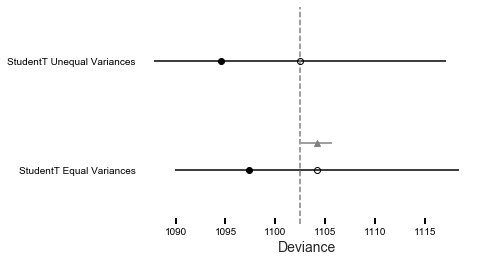

In [45]:
rc('text', usetex=False)
fig, axs = sb.mpl.pyplot.subplots(1, 1)
pm.compareplot(df_comp_WAIC, ax=axs)
z = axs
z.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
z.tick_params(direction='in', length=6, width=2, colors='k', which='major', left=False)
# z.tick_params(
#     direction='in', length=4, width=1, colors='k', which='minor', bottom=False)
z.xaxis.set_ticks_position('bottom')
z.spines['right'].set_visible(False)
z.spines['top'].set_visible(False)
z.spines['left'].set_visible(False)
z.spines['bottom'].set_visible(False)
# z.spines['left'].set_position(('outward', 10))
fig.savefig('model comparision, unequal and equal variances.pdf')

In [46]:
robust_unequal_var_loo = pm.loo(RobustUnequalVariancesTrace, RobustUnequalVariances)
robust_unequal_var_loo.LOO

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


1102.482570702907

In [47]:
StudentTEqualVar_loo = pm.loo(StudentTModelEqualVarianceTrace, StudentTModelEqualVariance)
StudentTEqualVar_loo.LOO

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  """Entry point for launching an IPython kernel.


1104.1673523353095

In [48]:
df_comp_LOO = pm.compare({RobustUnequalVariances: RobustUnequalVariancesTrace, StudentTModelEqualVariance: StudentTModelEqualVarianceTrace}, ic='LOO')
df_comp_LOO

,LOO,pLOO,dLOO,weight,SE,dSE,shape_warn
StudentT Unequal Variances,1102.48,3.95,0,1,14.61,0,0
StudentT Equal Variances,1104.17,3.42,1.68,0,14.25,1.54,0


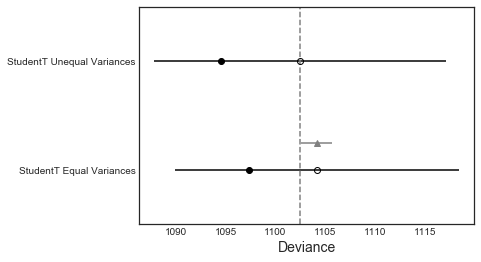

In [49]:
pm.compareplot(df_comp_LOO)

## working with cumulative data

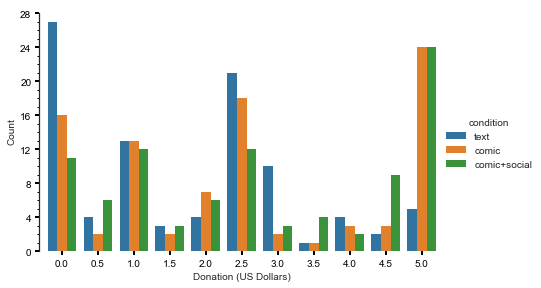

In [50]:
g = sb.catplot(
    hue="condition",
    data=df,
    hue_order=["text", "comic", "comic+social"],
    height=4,
    x="response",
    kind="count",
    aspect=1.5).set(yticks=np.arange(0, 30, 4)).set_axis_labels(
        "Donation (US Dollars)", "Count")

# custom limits requires us to tell where the majot and minor ticks are
majorLocator = MultipleLocator(4) 
minorLocator = MultipleLocator(2)

g.ax.yaxis.set_major_locator(majorLocator)
g.ax.yaxis.set_minor_locator(minorLocator)

g.ax.tick_params(direction='out', length=4, width=2, colors='k', which='major')
g.ax.tick_params(
    direction='out', length=2, width=1, colors='k', which='minor', bottom=False)
g.ax.minorticks_on()
g.despine(offset=5, left=False, bottom=True, trim=True)


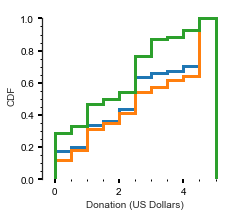

In [51]:
g = sb.FacetGrid(data=df, hue="condition")
g = g.map(
#     sb.distplot,
    plt.hist,
    "response",
    cumulative=True,
    density=True,
    linewidth=3,
    histtype='step'
#     kde=False,
#     norm_hist=True,
#     hist_kws=dict(
#         cumulative=True,
#         histtype='step',
#     linewidth=3)
).set_axis_labels(
            "Donation (US Dollars)", "CDF")

# majorLocator = MultipleLocator(0.2)
# minorLocator = MultipleLocator(0.1)

# g.ax.yaxis.set_major_locator(majorLocator)
# g.ax.yaxis.set_minor_locator(minorLocator)

g.ax.tick_params(direction='out', length=4, width=2, colors='k', which='major')
g.ax.tick_params(
    direction='out',
    length=2,
    width=1,
    colors='k',
    which='minor',
    bottom=True)
g.ax.minorticks_on()
g.despine(offset=5, left=False, bottom=True, trim=True)